In [7]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from collections import defaultdict, Counter

In [8]:
corpus = [
    ['USA Today']*5, 
    ['The Wall Street Journal']*20,
    ['The New York Times']*20,
    ['New York Post']*20,
    ['Los Angeles Times']*5,
    ['The Washington Post']*10,
    ['Star Tribune']*5,
    ['Chicago Tribue']*10,
    ['The Boston Globe']*10
]
corpus = [ne for l in corpus for ne in l]

In [9]:
scrapped_named_entities_counts = {
    'USA Today':5,
    'The Wall Street Journal':20,
    'The New York Times':20,
    'New York Post':20,
    'Los Angeles Times':5,
    'The Washington Post':10,
    'Star Tribune':5,
    'Chicago Tribue':10,
    'The Boston Globe':10,
}

In [20]:
# Do a word count
word_count = defaultdict(int)

for ne in corpus:
    words = ne.split(' ')
    for w in words:
        word_count[w] += 1
        
sorted_words = sorted(list(word_count.items()), key=lambda x: x[1], reverse=True)
sorted_words

[('The', 60),
 ('New', 40),
 ('York', 40),
 ('Post', 30),
 ('Times', 25),
 ('Wall', 20),
 ('Street', 20),
 ('Journal', 20),
 ('Washington', 10),
 ('Chicago', 10),
 ('Tribue', 10),
 ('Boston', 10),
 ('Globe', 10),
 ('USA', 5),
 ('Today', 5),
 ('Los', 5),
 ('Angeles', 5),
 ('Star', 5),
 ('Tribune', 5)]

In [22]:
word_set = [w for w,c in sorted_words]
word_set

['The',
 'New',
 'York',
 'Post',
 'Times',
 'Wall',
 'Street',
 'Journal',
 'Washington',
 'Chicago',
 'Tribue',
 'Boston',
 'Globe',
 'USA',
 'Today',
 'Los',
 'Angeles',
 'Star',
 'Tribune']

In [23]:
Vocab = {}
Vocab['w2i']={w:i for i, w in enumerate(word_set)}
Vocab['i2w']={i:w for i, w in enumerate(word_set)}

In [24]:
count_table = np.zeros((len(word_set), len(word_set)))

for ne in corpus:
    words = ne.split(' ')
    for w1, w2 in itertools.combinations(words, 2):
        count_table[Vocab['w2i'][w1], Vocab['w2i'][w2]] += 1
        count_table[Vocab['w2i'][w2], Vocab['w2i'][w1]] += 1

count_table

array([[ 0., 20., 20., 10., 20., 20., 20., 20., 10.,  0.,  0., 10., 10.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [20.,  0., 40., 20., 20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [20., 40.,  0., 20., 20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [10., 20., 20.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [20., 20., 20.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  5.,  5.,  0.,  0.],
       [20.,  0.,  0.,  0.,  0.,  0., 20., 20.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [20.,  0.,  0.,  0.,  0., 20.,  0., 20.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [20.,  0.,  0.,  0.,  0., 20., 20.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [10.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.

In [25]:
xy = count_table/np.sum(count_table)

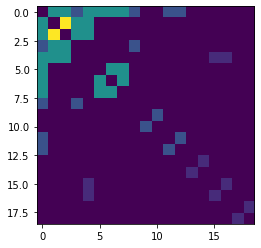

In [26]:
plt.imshow(xy)

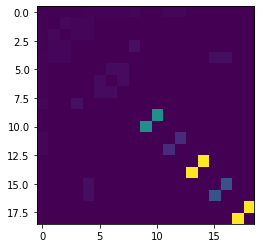

In [27]:
x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]
plt.imshow(xy/xyind)

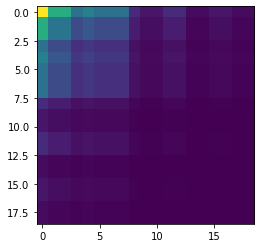

In [28]:
plt.imshow(xyind)

In [13]:
def run_expr(n_batch_b, n_batch_B, vocab, embed_size, iters):
    '''
    infoNCE
    '''
    torch.manual_seed(42)
    E = torch.nn.Embedding(len(Vocab['w2i']), embed_size)
    torch.nn.init.normal_(E.weight, mean=0., std=(0.01)**(1/2))
    print(E.weight.data[:2, :5])
    
    optimizer = torch.optim.SGD(E.parameters(),1, 0.99)
    Ebar = E.weight.data
    
    history = {'loss':[], 'E_var':[], 'gradients':[]}
    loss_B = 0
    
    for iteration in tqdm(range(1,iters)):
        
        samples = [np.random.choice(range(xy.reshape(-1).shape[0]), p=xy.reshape(-1)) for i in range(n_batch_b)]
        samples = np.array([(xi//x.shape[0], xi%x.shape[0]) for xi in samples])
        
        optimizer.zero_grad()
        
        # n_batch_b, embed_size
        x_samples = E(torch.tensor([x for x,y in samples]))
        # n_batch_b, embed_size
        y_samples = E(torch.tensor([y for x,y in samples]))
        
        loss_b = 0
        for i in range(n_batch_b):
            
            nom_x = torch.exp(torch.dot(x_samples[i], y_samples[i]))
            denom_x = torch.sum(torch.exp(torch.matmul(x_samples[i].unsqueeze(0), y_samples.T)))
            lossi_x = nom_x / denom_x
            
            nom_y = torch.exp(torch.dot(x_samples[i], y_samples[i]))
            denom_y = torch.sum(torch.exp(torch.matmul(y_samples[i].unsqueeze(0), x_samples.T)))
            lossi_y = nom_y / denom_y
            
            loss_b = loss_b + ((torch.log(lossi_x) + torch.log(lossi_y)) * 0.5)
        
        loss_b = -1*loss_b/n_batch_b
        
        # Accumulate loss to batch B
        loss_B += loss_b
        
        if iteration % n_batch_B == 0:
            loss = loss_B / n_batch_B
            loss.backward()
            history['gradients'].append(torch.mean(torch.absolute(E.weight.grad)).cpu().item())
            optimizer.step()
            history['loss'].append(loss.cpu().item())
            history['E_var'].append(torch.var(E.weight.data).cpu().item())
            Ebar = (1-1/iteration)*Ebar + (1/iteration)*E.weight.data
            loss_B = 0

        if iteration % 50 == 0:
            
            print(torch.var(E.weight.data)) #!!! ToDo should plot F instead
            
            F = torch.exp(torch.matmul(E.weight.data, E.weight.data.T))
            plt.imshow(F.detach().cpu().numpy()) #!!! ToDo should plot F instead
            
            plt.savefig(f"newspaper_training_bB_results/F_infoNCE_bB_{n_batch_b}_{n_batch_B}_{iteration}.png")

    np.save(f'newspaper_training_bB_results/Ebar_infoNCE_bB_{n_batch_b}_{n_batch_B}_{iteration}.npy', Ebar.detach().cpu().numpy())
    np.save(f'newspaper_training_bB_results/E_infoNCE_bB_{n_batch_b}_{n_batch_B}_{iteration}.npy', E.weight.data.detach().cpu().numpy())
    np.save(f'newspaper_training_bB_results/training_loss_infoNCE_bB_{n_batch_b}_{n_batch_B}_{iteration}.npy', np.array(history['loss']))
    return E, Ebar, history        

  4%|▍         | 4/99 [00:00<00:02, 38.91it/s]

tensor([[-0.0318,  0.1215,  0.1420, -0.0055,  0.0025],
        [ 0.0684, -0.1325, -0.0516,  0.0600,  0.0415]])


 58%|█████▊    | 57/99 [00:00<00:00, 65.84it/s]

tensor(nan)


100%|██████████| 99/99 [00:01<00:00, 79.20it/s]


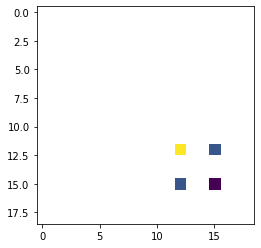

In [14]:
E, Ebar, history  = run_expr(n_batch_b=50, n_batch_B=1, vocab=Vocab, embed_size=20, iters=100)

In [91]:
history['loss']

[20.961545944213867,
 11.066514015197754,
 6.459082126617432,
 8.418659210205078,
 15.787873268127441,
 14.199901580810547,
 11.63984489440918,
 9.902584075927734,
 12.362784385681152,
 14.752937316894531,
 10.381041526794434,
 9.374065399169922,
 11.200287818908691,
 15.620593070983887,
 12.491927146911621,
 8.776477813720703,
 13.45745849609375,
 11.893834114074707,
 8.982126235961914,
 8.533663749694824,
 10.646493911743164,
 18.72426986694336,
 16.209915161132812,
 15.643284797668457,
 9.65835952758789,
 8.009428977966309,
 inf,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [92]:
E.weight.data

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [n

In [28]:
b.shape

torch.Size([2, 3])

In [ ]:
# v by embed_size, embed_size by v

In [33]:
E1 = torch.nn.Embedding(5,10)

In [37]:
E1.weight.data

tensor([[-0.8861,  1.0151, -1.1938,  0.1256, -0.8193, -0.4286,  2.2358,  0.0575,
          1.0349, -0.5117],
        [-1.3048,  0.9840, -0.0337,  0.5159, -0.2033, -0.7645,  0.9870, -0.0499,
         -0.0212,  1.1756],
        [-0.7436, -0.2535,  0.8155,  0.2760, -1.3243, -0.5104, -0.4147,  0.4566,
         -0.5119, -0.5716],
        [ 0.1240,  0.2662, -0.4660, -0.8304,  1.2067,  0.3586,  1.2879, -0.3648,
         -1.5717, -0.5275],
        [ 0.4110, -1.5234,  0.5938,  0.8308, -0.0407,  2.6929, -0.4422, -3.6095,
         -0.5941, -0.3820]])

In [38]:
E1.weight.data.shape

torch.Size([5, 10])

In [41]:
torch.exp(torch.matmul(E1.weight.data, E1.weight.data.T))

tensor([[3.4421e+04, 7.6315e+01, 6.8952e-01, 2.6431e+00, 5.2392e-03],
        [7.6315e+01, 3.7354e+02, 1.4946e+00, 8.7854e-01, 1.2652e-02],
        [6.8952e-01, 1.4946e+00, 7.6843e+01, 1.1714e-01, 2.3029e-01],
        [2.6431e+00, 8.7854e-01, 1.1714e-01, 1.2340e+03, 4.3833e+00],
        [5.2392e-03, 1.2652e-02, 2.3029e-01, 4.3833e+00, 4.4074e+10]])